# K-NN Training Overview
This notebook implements a full supervised machine-learning pipeline for plant-health classification using k-Nearest Neighbors (k-NN).

In [1]:
import os
import joblib
import random
import numpy as np
import pandas as pd

import pandas as pd

from typing import List
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder

from core.preprocessing import load_and_preprocess_data
from core.outlier_detection import remove_outliers
from core.feature_selection import select_features
from core.classification import (
    classify_with_knn,
    classify_with_knn_without_hyperparameter,
)
from core.visualization import (
    visualize_ground_truth,
    visualize_knn_decision_boundary,
)

from utils import find_project_root


## Setting Random Seeds
Ensures that any randomness in preprocessing or clustering is reproducible.
This allows consistent results when rerunning the notebook.

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)

## Data Loading & Preprocessing
Here, we load the plant-health dataset and perform basic preprocessing steps required before clustering.
We:
- Reads the CSV file.
- Removes non-informative columns (`Timestamp`, `Plant_ID`).
- Splits data into features (`X`) and labels (`y`).
- Fills missing values (if any) using column means.
- Encodes the target variable using `LabelEncoder` (for visualization).
- Standardizes numerical features using `StandardScaler` and returns both raw and scaled versions.

In [3]:
PROJECT_ROOT = find_project_root()

train_path = os.path.join(PROJECT_ROOT, "data", "train_data.csv")
test_path = os.path.join(PROJECT_ROOT, "data", "test_data.csv")

X_train_raw, X_test_raw, y_train, y_test, X_train_scaled, X_test_scaled, label_encoder, scaler = (
    load_and_preprocess_data(
        train_path,
        test_path
    )
)

## Outlier Removal
Identify and remove anomalous samples from a dataset using the Local Outlier Factor (LOF) algorithm. 
It takes a scaled feature matrix (`X_scaled`) and corresponding labels (`y_encoded`), 
detects outliers based on how isolated each sample is compared to its local neighborhood, 
and returns a cleaned dataset with outliers removed.

After detecting outliers: 
 - Filters out all samples labeled as outliers
 - Returns the cleaned feature matrix and labels
 - Visualizes inliers and outliers using the first two features

From the plot, the outliers (red Xs) appear randomly scattered away from high-density regions. This suggests random measurement errors or extreme anomalies 
as there is no visible structure or cluster pattern among the outliers.
- They do not group into a separate meaningful cluster.
- They do not represent a rare class.
- They are unlikely to contain useful information

Therefore, we decided to remove these found outliers.

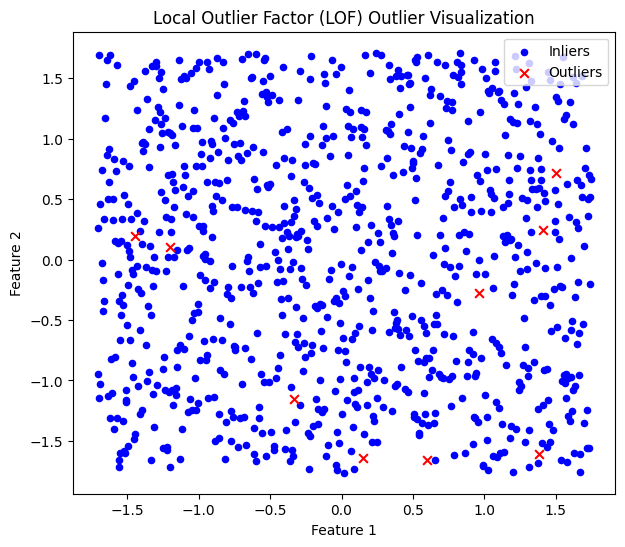

[Outlier Detection] Removed 9 outliers.


In [4]:
X_train_clean, y_train_clean = remove_outliers(
    X_train_scaled, # scaled version
    y_train
)

## Feature Selection
Perform feature selection using the `SelectKBest` with `Mutual Information` as the scoring metric. 
It evaluates how informative each feature is in predicting the target labels, 
selects the top k most relevant features, and returns:
 - `X_selected`: the transformed dataset containing only the selected features
 - `selected_features`: the names of the chosen features

This process helps reduce dimensionality, remove irrelevant inputs, 
and improve the performance and interpretability of ML models. 

Feature selection is a crucial step as without performing feature selection (see: `train_without_feature_selection.ipynb`), the model performance decreases approximately `5-10%`.

In [5]:
X_train_selected, selected_features = select_features(
    X_train_clean,
    y_train_clean,
    X_train_raw.columns,
    k=8
)

# Apply same feature selection to test set
X_test_selected = pd.DataFrame(
    scaler.transform(X_test_raw),
    columns=X_train_raw.columns
)[selected_features].values

[Feature Selection] Selected features: ['Unnamed: 0', 'Soil_Moisture', 'Ambient_Temperature', 'Soil_Temperature', 'Humidity', 'Soil_pH', 'Nitrogen_Level', 'Electrochemical_Signal']


## Visualization
Two visualizations are provided:
- Ground truth scatter of selected features
- k-NN decision boundary plot (using 2D PCA) to understand classifier behaviour

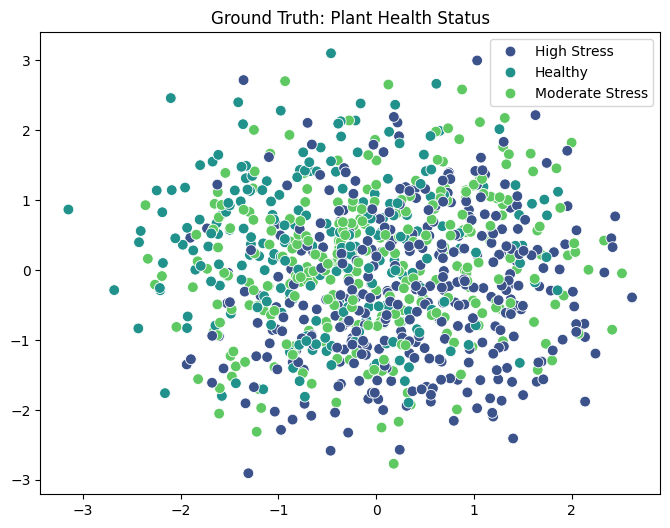

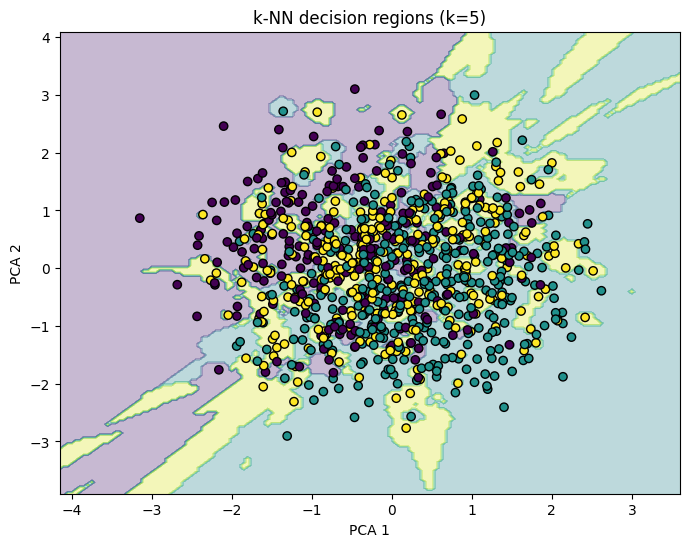

In [6]:
selected_scaler = StandardScaler()
X_train_selected_scaled = selected_scaler.fit_transform(X_train_selected)

visualize_ground_truth(X_train_selected_scaled, y_train_clean, label_encoder)
visualize_knn_decision_boundary(X_train_selected_scaled, y_train_clean, n_neighbors=5)

## Classification
Here we train `K-NN` classifier with hyperparameter tuning where
we search for optimal `k`.

With hyperparameter tuning, the `K-NN` classifier achieves approximately `76%` accuracy, compared to only `69%` accuracy without tuning (using `classify_with_knn_without_hyperparameter`). This shows that hyperparameter optimization provides a substantial performance gain for `K-NN`. 

Additionally, the poorest performance occurs when training `K-NN` without hyperparameter tuning and without feature selection, yielding only about `65%` accuracy, slightly better than a coin flip.

## ROC Curve
From the ROC Curve, the classifier distinguishes `Healthy` and `High Stress` extremely well, but is less confident when detecting `Moderate Stress`.

Running KNN with hyperparameter tuning...
[Classification] Best Params: {'n_neighbors': 15, 'weights': 'uniform'}


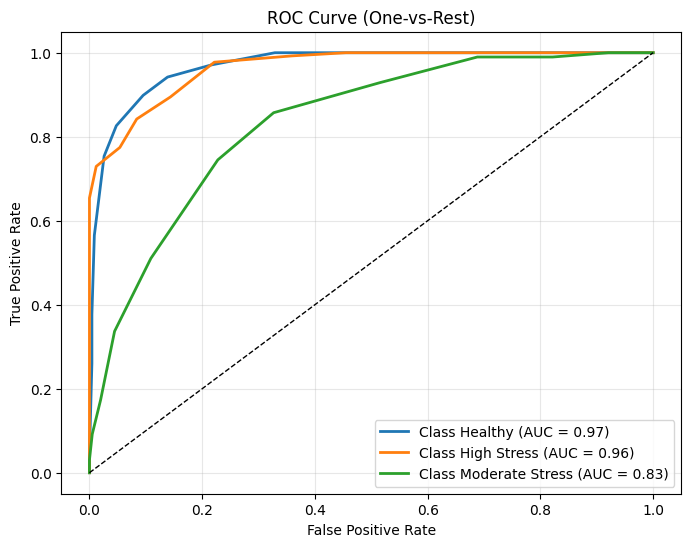

[Classification Report]
                 precision    recall  f1-score   support

        Healthy       0.77      0.80      0.79        69
    High Stress       0.88      0.83      0.86       133
Moderate Stress       0.70      0.73      0.72        98

       accuracy                           0.79       300
      macro avg       0.78      0.79      0.79       300
   weighted avg       0.80      0.79      0.79       300



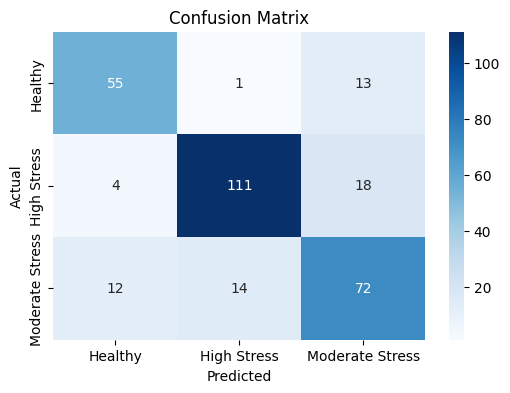

Fold scores: 0.7654698386793045
Mean: 0.7654698386793045 Std: 0.0
[Cross-validation Accuracy]: 0.7655


In [7]:
# Train classifier with hyperparameter
print("Running KNN with hyperparameter tuning...")
knn = classify_with_knn(
    X_train_selected_scaled,
    y_train_clean,
    label_encoder,
    X_test=X_test_selected,
    y_test=y_test
)